In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
from warnings import simplefilter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
import optuna
from optuna.integration import CatBoostPruningCallback

from src.constants import SEED, CAT_FEATURES, TARGET_FEATURE

In [2]:
simplefilter("ignore")

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

## Load data

In [5]:
data_raw = pd.read_csv("../data/telecom/cell2celltrain.csv")
data = data_raw.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [7]:
data = data.drop(columns=["ServiceArea"])
data.Churn = data.Churn.replace({"Yes": 1, "No": 0})
data[CAT_FEATURES] = data[CAT_FEATURES].fillna("NaN")
data[CAT_FEATURES] = data[CAT_FEATURES].astype("category")
data = data.fillna(np.nan)

In [8]:
y = data[TARGET_FEATURE]
X = data.drop(columns=[TARGET_FEATURE, "CustomerID"])

## Tune hyperparameters

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.08, random_state=SEED)

In [10]:
DEFAULT_PARAMS = {
            "objective": "Logloss",
            "iterations": 1000,
            "eval_metric": "Accuracy",
            "logging_level": "Silent",
            "cat_features": CAT_FEATURES,
            "random_state": SEED,
}

In [11]:
def objective(trial):
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    param.update(DEFAULT_PARAMS)
    

    gbm = CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(X_train, 
             y_train, 
             eval_set=[(X_val, y_val)], 
             verbose=0, 
             early_stopping_rounds=100,
             callbacks=[pruning_callback],
             )
    
    pruning_callback.check_pruned()

    y_pred = gbm.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, n_jobs=-1)

[I 2024-08-08 23:28:24,285] A new study created in memory with name: no-name-e8c71c46-31eb-484e-ad46-884ccc9d5d26
[I 2024-08-08 23:28:28,793] Trial 0 finished with value: 0.7101316192225283 and parameters: {'colsample_bylevel': 0.014408780177207292, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.004516158219641207, 'l2_leaf_reg': 1.242785859255918, 'border_count': 133, 'bagging_temperature': 1.5710427271902283}. Best is trial 0 with value: 0.7101316192225283.
[I 2024-08-08 23:28:29,917] Trial 3 finished with value: 0.7089072543617998 and parameters: {'colsample_bylevel': 0.021353109173958974, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.005896274809357095, 'l2_leaf_reg': 1.546509998592864, 'border_count': 158}. Best is trial 0 with value: 0.7101316192225283.
[I 2024-08-08 23:28:30,167] Trial 4 finished with value: 0.7101316192225283 a

In [13]:
print("Best params were:", study.best_params)

Best params were: {'colsample_bylevel': 0.02517092925399281, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.02996164560564048, 'l2_leaf_reg': 1.7389157219998492, 'border_count': 133, 'bagging_temperature': 1.1103875329741897}


In [14]:
final_model = CatBoostClassifier(**study.best_params, **DEFAULT_PARAMS)

In [15]:
final_model.fit(X_train, y_train)

In [16]:
y_pred = final_model.predict(X_test)

Text(0.5, 1.0, 'Feature Importance')

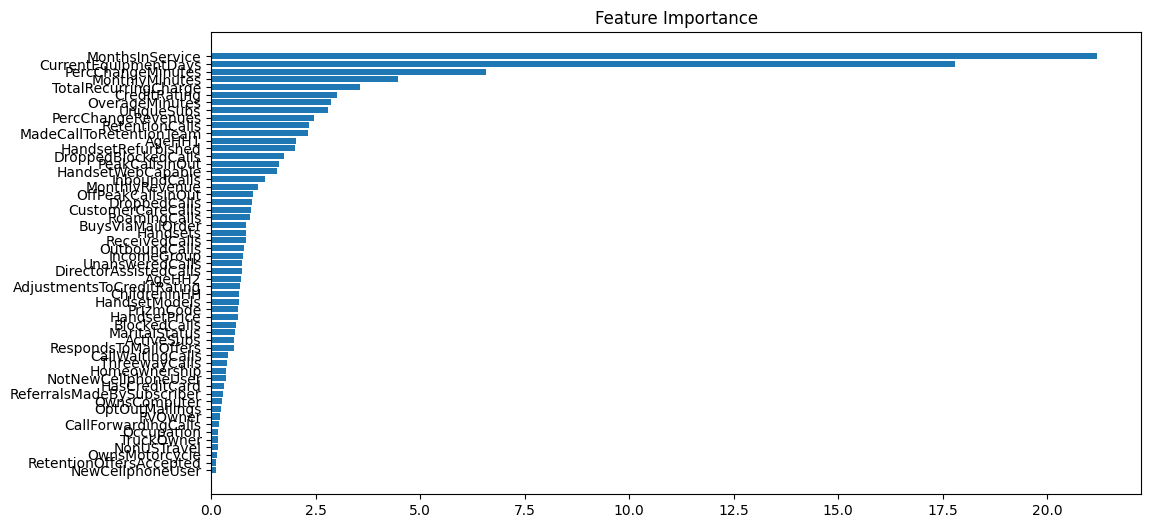

In [17]:
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance")

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      7237
           1       0.52      0.19      0.28      2973

    accuracy                           0.71     10210
   macro avg       0.63      0.56      0.55     10210
weighted avg       0.67      0.71      0.66     10210



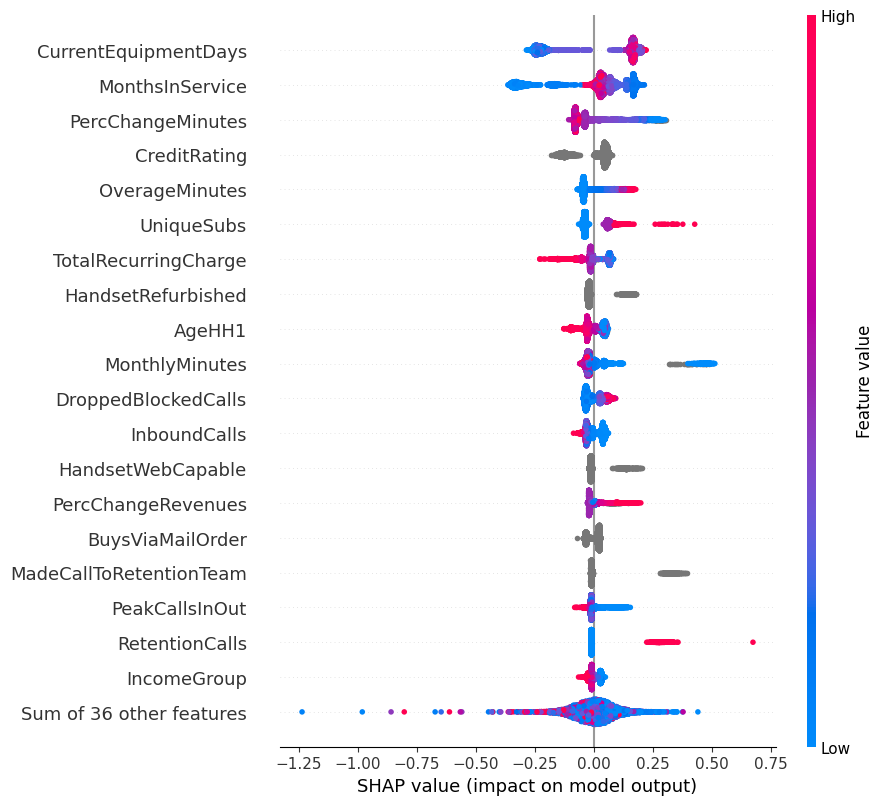

In [19]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=20)

In [23]:
def save_df_to_csv(df, filename='data.csv'):
    df.to_csv(filename, index=False)

y_pred_df = pd.DataFrame({'Prediction': y_pred})

save_df_to_csv(y_pred_df, 'final_prediction.csv')